In [2]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass
from compass.utils import plot_embed_with_label, score
from compass.tokenizer import CANCER_CODE, CONCEPT


In [3]:
from compass.tokenizer import CONCEPT_palette
from compass.utils import plot_sankey_diagram, get_projector_weights

In [8]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


In [16]:
def km_plot(df, colormap={'$P_{(R)} >= 0.5$': 'darkblue', '$P_{(R)} < 0.5$': 'red'}, cohort='IMvigor210'):
    from lifelines.statistics import logrank_test
    from lifelines import KaplanMeierFitter
    import matplotlib.pyplot as plt
    
    # 分组数据
    group_1 = df[df['Pred_Response'] == '$P_{(R)} >= 0.5$']
    group_2 = df[df['Pred_Response'] == '$P_{(R)} < 0.5$']

    # 计算 Log-Rank 检验的 p 值
    results = logrank_test(
        group_1['OS_Months'], group_2['OS_Months'],
        event_observed_A=group_1['OS_Event'],
        event_observed_B=group_2['OS_Event']
    )
    p_value = results.p_value
    formatted_p_value = f"{p_value:.2g}"  # 保留 2 位有效小数
    
    # 绘制 Kaplan-Meier 曲线
    kmf = KaplanMeierFitter()
    
    fig, ax = plt.subplots(figsize=(5.5, 5))
    
    for group in df['Pred_Response'].unique():
        # 获取分组索引和样本数
        group_idx = df['Pred_Response'] == group
        n_samples = group_idx.sum()  # 当前组样本数
    
        # 拟合数据并添加带样本数的标签
        kmf.fit(
            durations=df['OS_Months'][group_idx],
            event_observed=df['OS_Event'][group_idx],
            label=f'{group} (n = {n_samples})'
        )
        kmf.plot_survival_function(
            ax=ax,
            color=colormap[group],
            show_censors=True,     # 显示截尾点
            ci_show=True,
            ci_alpha=0.1,
            drawstyle='steps-post'
        )

        # 获取 12 月的生存率和置信区间
        time_point = 12
        survival_rate = kmf.predict(time_point)
        ci = kmf.confidence_interval_.asof(time_point)
        
        # 检查置信区间列名
        lower_ci_col = ci.index[0]  # 获取第一个列名（下限）
        upper_ci_col = ci.index[1]  # 获取第二个列名（上限）
        
        lower_ci = ci[lower_ci_col]
        upper_ci = ci[upper_ci_col]

        # 打印生存率和置信区间
        print(f"12-month survival rate for {group}: {survival_rate:.2f} (95% CI: {lower_ci:.2f}-{upper_ci:.2f})")
        
        # # 在图表上标注 12 月的生存率和置信区间
        # ax.annotate(
        #     f"{survival_rate:.2f} (95% CI: {lower_ci:.2f}-{upper_ci:.2f})",
        #     xy=(time_point, survival_rate),
        #     xytext=(time_point + 2, survival_rate - 0.1),
        #     arrowprops=dict(arrowstyle='->', color=colormap[group]),
        #     fontsize=10,
        #     color=colormap[group]
        # )

    formatted_p_value = f"{p_value:.1e}".replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    formatted_p_value = f"$P = {formatted_p_value}"
    
    # 添加 p 值到图表顶部
    ax.set_title(f"{cohort}\nLog-Rank Test {formatted_p_value}", pad=20)
    
    # 修改坐标轴
    ax.set_xlabel("Time (Months)")
    ax.set_ylabel("Overall Survival (%)")
    
    # 添加 12 月的竖直虚线
    ax.axvline(x=12, color='black', linestyle='--', linewidth=1, alpha=0.8)
    
    # 修改 Y 轴为百分比
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
    
    ax.set_xlim(left=0)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='major', right=False, top=False, direction='out', reset=True)
    ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines[['right', 'top']].set_visible(False)
    
    return fig


In [17]:
data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE.ALIGN'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 26))

In [6]:
# IMVigor210	298	2
# Liu	107	2
# SU2CLC1	102	2
# Rose	89	2
# Gide	73	2
# Riaz	51	2
# Allen	39	2
# MGH	34	2
# Hugo	26	2
# SU2CLC2	25	2
# Snyder	21	2

Downloading...
From: https://www.immuno-compass.com/download/model/LOCO/pft_leave_IMVigor210.pt
To: /tmp/tmp6emf7991
100%|██████████| 35.1M/35.1M [00:58<00:00, 603kB/s]


Model downloaded to: /tmp/tmp6emf7991


100%|##########| 18/18 [00:02<00:00,  6.87it/s]


12-month survival rate for $P_{(R)} < 0.5$: 0.40 (95% CI: 0.34-0.46)
12-month survival rate for $P_{(R)} >= 0.5$: 0.86 (95% CI: 0.71-0.93)


Downloading...
From: https://www.immuno-compass.com/download/model/LOCO/pft_leave_Liu.pt
To: /tmp/tmpuxvceqtu
100%|██████████| 35.1M/35.1M [00:57<00:00, 609kB/s]


Model downloaded to: /tmp/tmpuxvceqtu


100%|##########| 18/18 [00:02<00:00,  6.71it/s]


12-month survival rate for $P_{(R)} < 0.5$: 0.60 (95% CI: 0.48-0.70)
12-month survival rate for $P_{(R)} >= 0.5$: 0.88 (95% CI: 0.67-0.96)


Downloading...
From: https://www.immuno-compass.com/download/model/LOCO/pft_leave_SU2CLC1.pt
To: /tmp/tmph6gijv62
100%|██████████| 35.1M/35.1M [00:55<00:00, 627kB/s]


Model downloaded to: /tmp/tmph6gijv62


100%|##########| 18/18 [00:02<00:00,  6.78it/s]


12-month survival rate for $P_{(R)} < 0.5$: 0.59 (95% CI: 0.46-0.70)
12-month survival rate for $P_{(R)} >= 0.5$: 0.85 (95% CI: 0.64-0.94)


Downloading...
From: https://www.immuno-compass.com/download/model/LOCO/pft_leave_Gide.pt
To: /tmp/tmp017ooz61
100%|██████████| 35.1M/35.1M [00:57<00:00, 610kB/s]


Model downloaded to: /tmp/tmp017ooz61


100%|##########| 18/18 [00:02<00:00,  6.79it/s]


12-month survival rate for $P_{(R)} >= 0.5$: 0.86 (95% CI: 0.69-0.94)
12-month survival rate for $P_{(R)} < 0.5$: 0.62 (95% CI: 0.45-0.76)


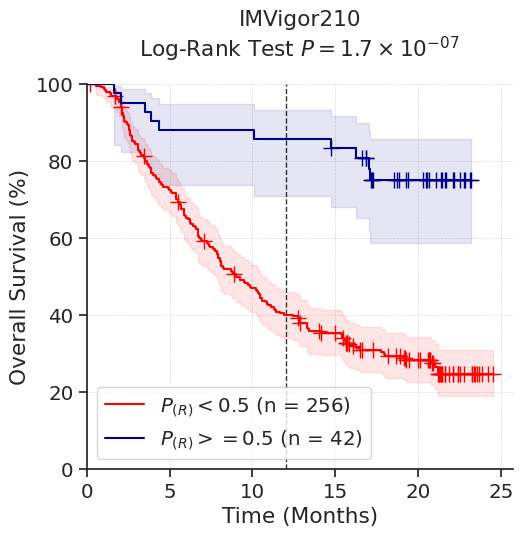

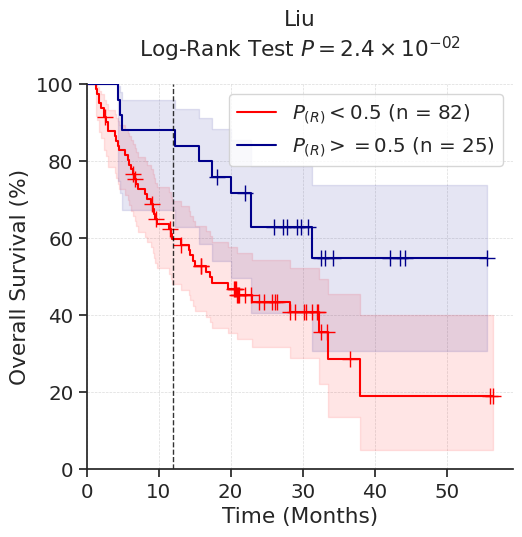

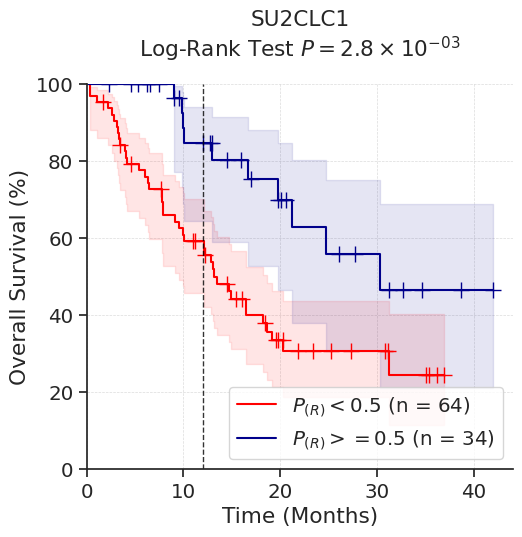

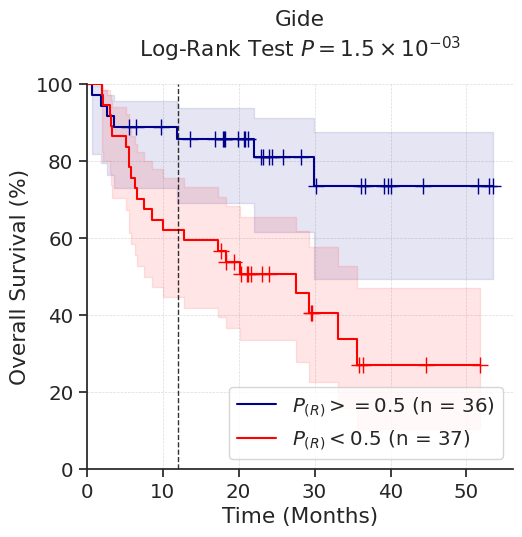

In [19]:
for cohort in['IMVigor210', 'Liu', 'SU2CLC1', 'Gide']:
    # load the pretrained model as a feature extractor
    finetuner = loadcompass('https://www.immuno-compass.com/download/model/LOCO/pft_leave_%s.pt' % cohort)
    
    dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
    dfgn, dfgs, dfct = finetuner.extract(dfcx,  batch_size= 64, with_gene_level = True)
    _, dfpred = finetuner.predict(dfcx, batch_size=64)
    
    sidx = df_label[df_label.cohort == cohort].index
    dfcl = df_label.loc[sidx].dropna(axis=1, how='all')
    dfpred = dfpred.loc[sidx]
    df = dfcl[['OS_Months','OS_Event']] 
    df['Pred_Response'] = dfpred[1].apply(lambda x: '$P_{(R)} >= 0.5$' if x >= 0.5 else '$P_{(R)} < 0.5$')
    fig = km_plot(df.dropna(), cohort = cohort)
    fig.savefig('km_%s.pdf' % cohort, bbox_inches='tight',)
    fig.savefig('km_%s.svg' % cohort, bbox_inches='tight',)
    df.to_pickle('km_%s.pkl' % cohort)